# Using Trade Dependence to Improve the Donchian Breakout Trading Strategy

Looking into the donchian channel breakout strategy's dependence between trades.  I show that trades following a prior losing signal are often better, and trades following a prior winning signal are not very good.The turtle used traded a very similar strategy. 

* Tutorial: [Using Trade Dependence to Improve the Donchian Breakout Trading Strategy](https://www.youtube.com/watch?v=BM3KZPg6zic)
* Code: https://github.com/neurotrader888/TradeDependenceRunsTest

Links

- https://en.wikipedia.org/wiki/Wald–Wolfowitz_runs_test
- https://www.investopedia.com/articles/trading/08/turtle-trading.asp

In [1]:
import pandas as pd
import numpy as np
import scipy
import pandas_ta as ta
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

### Donchian Breakout

In [2]:
def donchian_breakout(df: pd.DataFrame, lookback: int):
    # input df is assumed to have a 'close' column
    df['upper'] = df['close'].rolling(lookback - 1).max().shift(1)
    df['lower'] = df['close'].rolling(lookback - 1).min().shift(1)
    df['signal'] = np.nan
    df.loc[df['close'] > df['upper'], 'signal'] = 1
    df.loc[df['close'] < df['lower'], 'signal'] = -1
    df['signal'] = df['signal'].ffill()

def get_trades_from_signal(data: pd.DataFrame, signal: np.array):
    # Gets trade entry and exit times from a signal
    # that has values of -1, 0, 1. Denoting short,flat,and long.
    # No position sizing.

    long_trades = []
    short_trades = []

    close_arr = data['close'].to_numpy()
    last_sig = 0.0
    open_trade = None
    idx = data.index
    for i in range(len(data)):
        if signal.iloc[i] == 1.0 and last_sig != 1.0: # Long entry
            if open_trade is not None:
                open_trade[2] = idx[i]
                open_trade[3] = close_arr[i]
                short_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]
        if signal.iloc[i] == -1.0  and last_sig != -1.0: # Short entry
            if open_trade is not None:
                open_trade[2] = idx[i]
                open_trade[3] = close_arr[i]
                long_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]
        
        if signal.iloc[i] == 0.0 and last_sig == -1.0: # Short exit
            open_trade[2] = idx[i]
            open_trade[3] = close_arr[i]
            short_trades.append(open_trade)
            open_trade = None

        if signal.iloc[i] == 0.0  and last_sig == 1.0: # Long exit
            open_trade[2] = idx[i]
            open_trade[3] = close_arr[i]
            long_trades.append(open_trade)
            open_trade = None

        last_sig = signal.iloc[i]

    long_trades = pd.DataFrame(long_trades, columns=['entry_time', 'entry_price', 'exit_time', 'exit_price'])
    short_trades = pd.DataFrame(short_trades, columns=['entry_time', 'entry_price', 'exit_time', 'exit_price'])

    long_trades['return'] = (long_trades['exit_price'] - long_trades['entry_price']) / long_trades['entry_price']
    short_trades['return'] = -1 * (short_trades['exit_price'] - short_trades['entry_price']) / short_trades['entry_price']
    long_trades = long_trades.set_index('entry_time')
    short_trades = short_trades.set_index('entry_time')
    
    long_trades['type'] = 1
    short_trades['type'] = -1
    all_trades = pd.concat([long_trades, short_trades])
    all_trades = all_trades.sort_index()
    
    return long_trades, short_trades, all_trades

In [3]:
# Load data
data = pd.read_csv('src/BTCUSDT3600.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')
data = data.dropna()

In [4]:
data['r'] = np.log(data['close']).diff().shift(-1)
donchian_breakout(data, 24)
plt.style.use('dark_background')

In [5]:
# data['close'].plot()
# data['upper'].plot(color='green')
# data['lower'].plot(color='red')
# plt.twinx()
# data['signal'].plot(color='orange')
# plt.show()

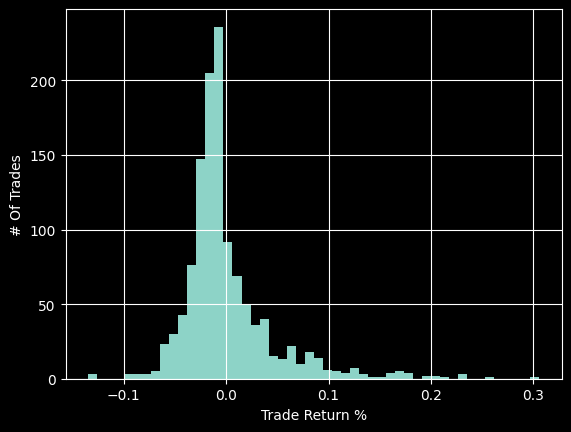

In [6]:
long_trades, short_trades, all_trades = get_trades_from_signal(data, data['signal']) 
all_trades['return'].hist(bins=50)
plt.xlabel("Trade Return %")
plt.ylabel("# Of Trades")
plt.show()

In [7]:
rets = data['r'] * data['signal']
pf = rets[rets>0].sum() / rets[rets<0].abs().sum()
print("Profit Factor", pf)
print("Avg Trade", all_trades['return'].mean())
print("Win Rate", len(all_trades[all_trades['return'] > 0]) / len(all_trades))

Profit Factor 1.009591634228182
Avg Trade 0.0008217837966010512
Win Rate 0.32172470978441126


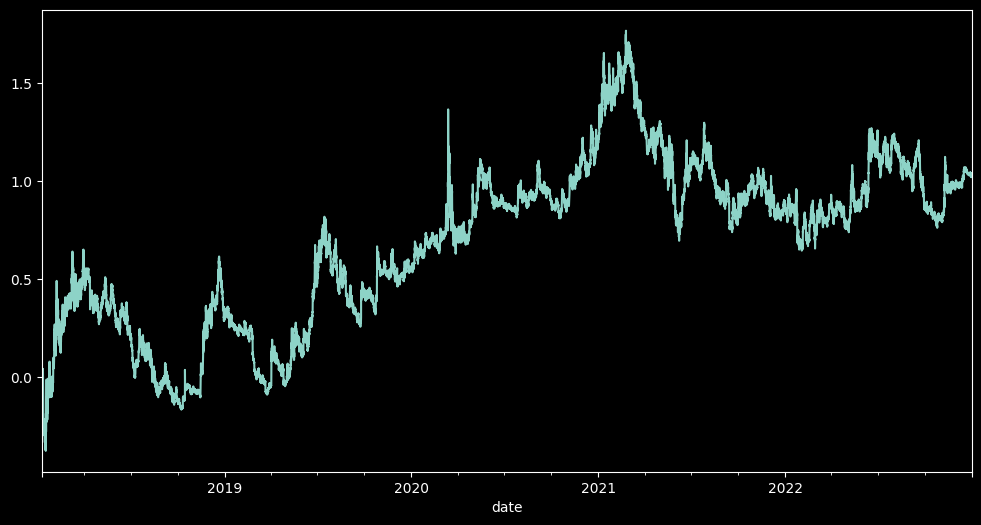

In [8]:
plt.figure(figsize=(12, 6))
(data['r'] * data['signal']).cumsum().plot()
plt.show()

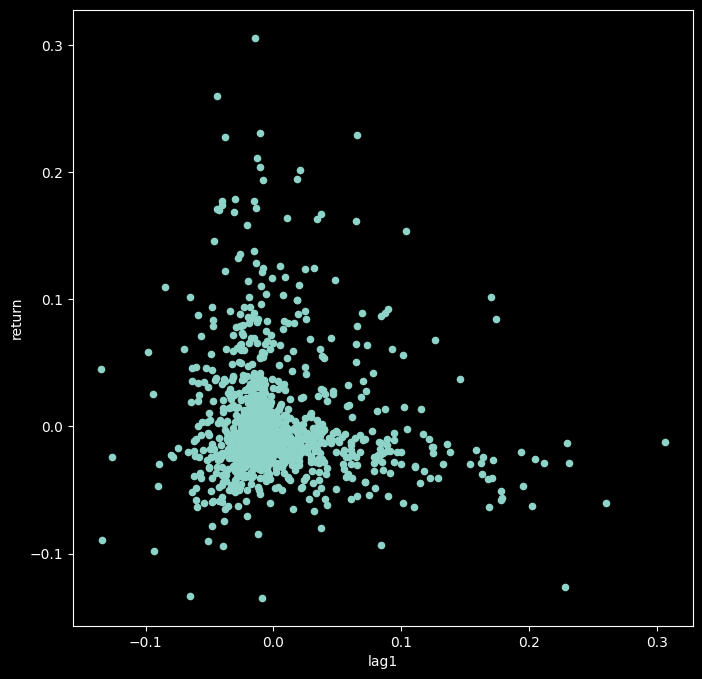

In [9]:
all_trades['lag1'] = all_trades['return'].shift(1)
all_trades.plot.scatter('lag1', 'return', figsize=(8, 8))
plt.show()

### Runs Test

In [10]:
def runs_test(signs: np.array):
    # signs must consist of only 1 and -1
    # Returns Z-Score of observed runs 
    assert len(signs) >= 2
    
    n_pos = len(signs[signs > 0])
    n_neg = len(signs[signs < 0])
    n = len(signs)
    
    # Mean number of expected runs
    mean = 2 * n_pos * n_neg / n  + 1
    # Stadard of expected runs
    std = (mean - 1) * (mean - 2) / ( n - 1 ) # Variance
    std = std ** 0.5

    #print(mean)
    #print(std**2)
    #print(std)
   
    # Count observed runs
    runs = 1
    for i in range(1, len(signs)):
        if signs[i] != signs[i-1]:
            runs += 1 # Streak broken
    #print(runs)
    # Z-Score
    z = (runs - mean) / std
    return z

In [11]:
# Load data
data = pd.read_csv('src/BTCUSDT3600.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')
data = data.dropna()

In [12]:
donchian_breakout(data, 24)
_, _, all_trades = get_trades_from_signal(data, data['signal'])
signs = np.sign(all_trades['return']).to_numpy()
runs_z = runs_test(signs)
# For 24 we get 2.7...
print("Donchian Breakout 24 Z-Score:", runs_z)

Donchian Breakout 24 Z-Score: 2.75005311006614


In [13]:
all_runs_z = []
lookbacks = list(range(12, 169, 2))
for lookback in tqdm(lookbacks):
    donchian_breakout(data, lookback)
    _, _, all_trades = get_trades_from_signal(data, data['signal'])
    signs = np.sign(all_trades['return']).to_numpy()
    runs_z = runs_test(signs)

    all_runs_z.append(runs_z)

100%|███████████████████████████████████████████████████████████████████| 79/79 [00:29<00:00,  2.69it/s]


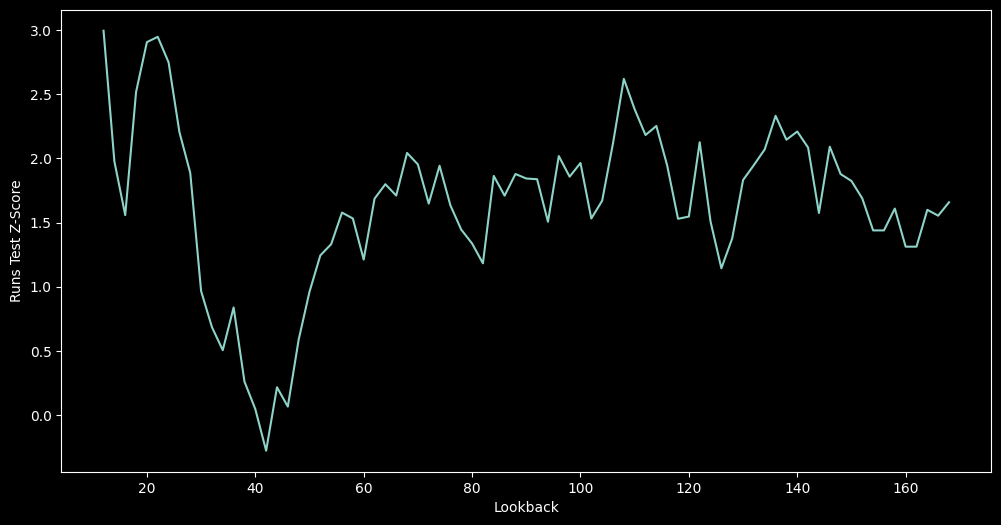

In [14]:
plt.style.use('dark_background')
pd.Series(all_runs_z, index=lookbacks).plot(figsize=(12, 6))
plt.xlabel("Lookback")
plt.ylabel("Runs Test Z-Score")
plt.show()

### Last Trade Signal

In [15]:
def last_trade_adj_signal(ohlc: pd.DataFrame, signal: np.array, last_winner: bool = False):
    # Input signal must be long and short, only having values of 1 and -1.
    # Adjust a signal to only trade if last trade was a winner/loser

    last_type = -1
    if last_winner:
        last_type = 1
    
    close = ohlc['close'].to_numpy()
    mod_signal = np.zeros(len(signal))

    long_entry_p = np.nan
    short_entry_p = np.nan
    last_long = np.nan
    last_short = np.nan

    last_sig = 0.0
    for i in range(len(close)):
        if signal[i] == 1.0 and last_sig != 1.0: # Long entry
            long_entry_p = close[i]
            if not np.isnan(short_entry_p):
                last_short = np.sign(short_entry_p - close[i])
                short_entry_p = np.nan

        if signal[i] == -1.0  and last_sig != -1.0: # Short entry
            short_entry_p = close[i]
            if not np.isnan(long_entry_p):
                last_long = np.sign(close[i] - long_entry_p)
                long_entry_p = np.nan
        
        last_sig = signal[i]
        
        if signal[i] == 1.0 and last_short == last_type:
            mod_signal[i] = 1.0
        if signal[i] == -1.0 and last_long == last_type:
            mod_signal[i] = -1.0
        
    return mod_signal

In [16]:
# Load data
data = pd.read_csv('src/BTCUSDT3600.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')
data = data.dropna()

In [17]:
data['r'] = np.log(data['close']).diff().shift(-1)
donchian_breakout(data, 24)
data['last_lose'] = last_trade_adj_signal(data, data['signal'].to_numpy(), last_winner=False)
data['last_win'] = last_trade_adj_signal(data, data['signal'].to_numpy(), last_winner=True)
   
orig = data['r'] * data['signal']
lose = data['r'] * data['last_lose']
win = data['r'] * data['last_win']
print("Original PF", orig[orig > 0].sum() / orig[orig < 0].abs().sum())
print("Last Lose PF", lose[lose > 0].sum() / lose[lose < 0].abs().sum())
print("Last Win PF", win[win > 0].sum() / win[win < 0].abs().sum())

Original PF 1.009591634228182
Last Lose PF 1.0270503427104187
Last Win PF 0.9763077681782744


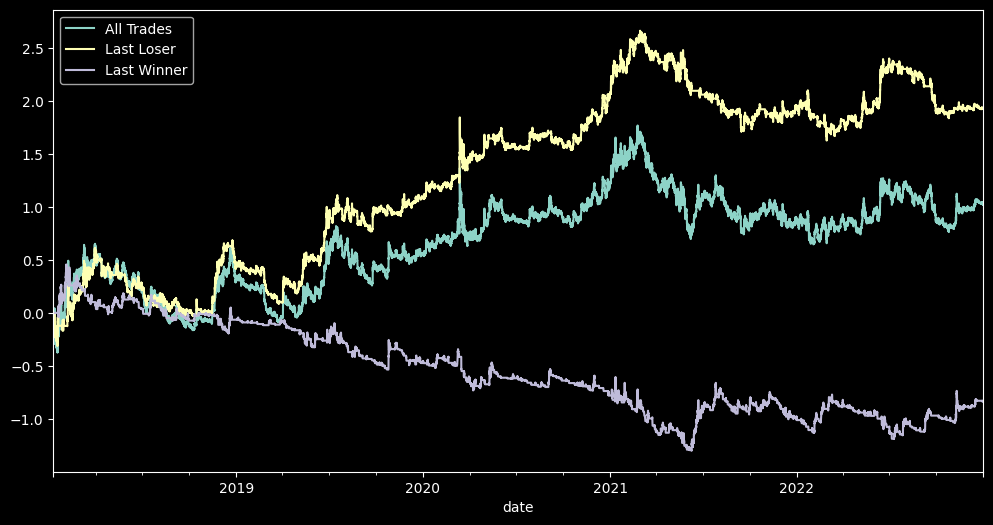

In [18]:
plt.style.use('dark_background')
plt.figure(figsize=(12, 6))
orig.cumsum().plot(label='All Trades')
lose.cumsum().plot(label='Last Loser')
win.cumsum().plot(label='Last Winner')
plt.legend()
plt.show()

In [19]:
# Compute across many lookbacks
lookbacks = list(range(12, 169, 6))
pfs = []
types = []
lbs = []
for lookback in lookbacks:
    donchian_breakout(data, lookback)
    data['last_lose'] = last_trade_adj_signal(data, data['signal'].to_numpy(), last_winner=False)
    data['last_win'] = last_trade_adj_signal(data, data['signal'].to_numpy(), last_winner=True)

    orig = data['r'] * data['signal']
    lose = data['r'] * data['last_lose']
    win = data['r'] * data['last_win']

    pfs.append ( np.log( orig[orig > 0].sum() / orig[orig < 0].abs().sum() ) )
    lbs.append(lookback)
    types.append("All")

    pfs.append (np.log( lose[lose > 0].sum() / lose[lose < 0].abs().sum() ) )
    lbs.append(lookback)
    types.append("Last Loser")

    pfs.append ( np.log( win[win > 0].sum() / win[win < 0].abs().sum() ) )
    lbs.append(lookback)
    types.append("Last Winner")

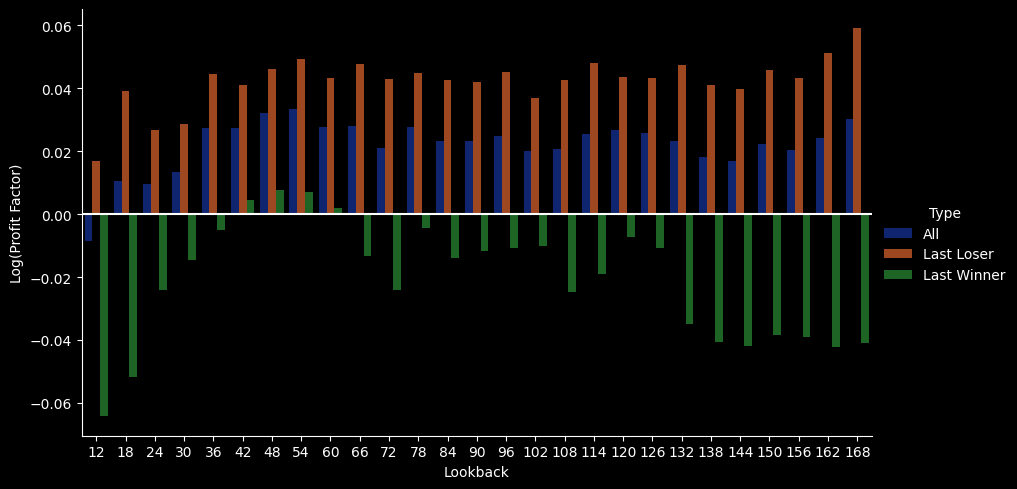

In [20]:
df = pd.DataFrame()
df['Lookback'] = lbs
df['Type'] = types
df['Log(Profit Factor)'] = pfs

plt.style.use('dark_background')
sns.catplot(
    data=df, y="Log(Profit Factor)", x='Lookback', hue="Type", kind='bar',
    palette="dark", edgecolor=".6", legend='auto', height=5, aspect=1.8
)
plt.axhline(0.0, color='white')
# plt.legend(prop={'size': 16}, title='Signal Type')
plt.show()

### Runs Indicator

In [21]:
# Didnt include in video, but I've seen talk online about
# using the runs test as an indicator
# Here I compute the runs test z-score using the signs of returns
# in a rolling window. I have not researched this much, idk if its any good.
# But its a well normalized indicator for yoru collection, have fun.

def runs_trend_indicator(close: pd.Series, lookback: int):
    change_sign = np.sign(close.diff()).to_numpy()
    ind = np.zeros(len(close))
    ind[:] = np.nan

    for i in range(lookback, len(close)):
        ind[i] = runs_test(change_sign[i - lookback + 1: i+1])

    return ind

In [22]:
data = pd.read_csv('src/BTCUSDT3600.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')
data = data.dropna()

data['runs_ind'] = runs_trend_indicator(data['close'], 24)

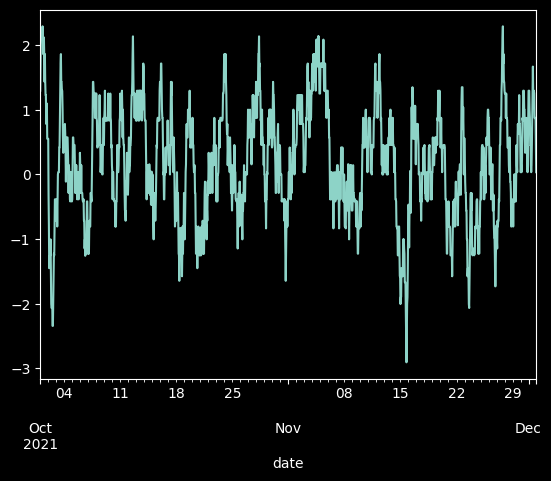

In [23]:
data['runs_ind']['2021-10-01':'2021-12-01'].plot()
plt.show()